In [506]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
import numpy as np
import functools
from torchvision import transforms as T
import torch

In [22]:
from physion import load_fitvid

In [3]:
model = load_fitvid() # pretrained

### image preprocessing

In [28]:
def load_preprocess_images_torch(image_filepaths, image_size, video_length=5):
    """
    define custom pre-processing here since R3M does not normalize like other models
    :seealso: r3m/example.py
    """
    images = load_images(image_filepaths)
    # preprocessing
    transforms = T.Compose([
        T.Resize(image_size),
        T.ToTensor(),  # ToTensor() divides by 255
        lambda img: img.repeat(video_length, 1, 1, 1),
        #lambda img: img.unsqueeze(0),
    ])
    images = [transforms(img) for img in images ]
    images = torch.stack(images, dim=0)
    return images

In [36]:
def load_preprocess_images(image_filepaths, image_size, video_length=5):
    """
    define custom pre-processing here since R3M does not normalize like other models
    :seealso: r3m/example.py
    """
    images = load_images(image_filepaths)
    # preprocessing
    transforms = T.Compose([
        T.Resize(image_size),
        T.ToTensor(),  # ToTensor() divides by 255
        lambda img: img.repeat(video_length, 1, 1, 1),
        lambda img: img.unsqueeze(0),
    ])
    images = [transforms(img) for img in images ]
    images = np.concatenate(images)
    return images

In [17]:
x = np.random.randint(10, size=(3, 64, 64))

In [23]:
y = np.tile(x, (5, 1, 1, 1))

In [24]:
y.shape

(5, 3, 64, 64)

In [25]:
(y[0] == y[1]).all()

True

In [5]:
path = '/home/yamins/.local/lib/python3.7/site-packages/model_tools/check_submission/images'

In [6]:
from model_tools.activations.pytorch import PytorchWrapper, load_images

In [428]:
os.listdir('/home/yamins/.local/lib/python3.7/site-packages/model_tools/check_submission/images')

['9.png',
 '4.png',
 '20.png',
 '11.png',
 '5.png',
 '19.png',
 '3.png',
 '8.png',
 '7.png',
 '15.png',
 '12.png',
 '6.png',
 '17.png',
 '16.png',
 '14.png',
 '18.png',
 '1.png',
 '2.png',
 '10.png',
 '13.png']

In [431]:
import os
image_filepaths = [os.path.join(path, '%d.png' % i) for i in range(1, 21)]

In [432]:
images = load_preprocess_images(image_filepaths, 64)

In [433]:
images.shape

(20, 5, 3, 64, 64)

### looking at the model

In [12]:
model

FitVid(
  (encoder): NvaeEncoder(
    (blocks): ModuleList(
      (0): ModuleList(
        (0): EncoderBlock(
          (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
          (shortcut): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (normalize_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (normalize_hidden): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (normalize_residual): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (se): SEBlock(
            (squeeze): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
            (expand): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (act): SiLU()
        )
        (1): EncoderBlock(
          (conv1): Conv2d(64, 64, kernel_size

In [568]:
import physion.models.fitvid as fitvid
from torch import nn, Tensor
from typing import Dict, Iterable, Callable

class Slicer(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x[0][:, 0]
    
class Postprocess(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self.slicers = torch.nn.ModuleDict({layer.replace('.', '__'): Slicer() for layer in layers})
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        _ = self.model(x)
        return {layer: self.slicers[layer.replace('.', '__')](self._features[layer]) for layer in self.layers}


In [492]:
model = load_fitvid() # pretrained

In [493]:
model.decoder.output_conv

Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)

In [497]:
preprocessing = functools.partial(load_preprocess_images, image_size=64)
wrapper = PytorchWrapper(identifier='fitvid', model=model, preprocessing=preprocessing)
wrapper.image_size = 64

In [523]:
out = wrapper.get_activations(images, ['decoder.output_conv'])

AssertionError: No submodule found for layer decoder.output_conv, at part decoder

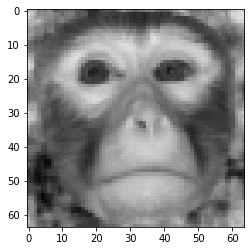

In [522]:
plt.imshow(images[18, 0].swapaxes(0, 1).swapaxes(1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


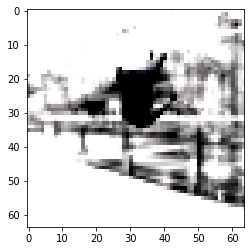

In [518]:
plt.imshow(out['decoder.output_conv'][0].swapaxes(0, 1).swapaxes(1, 2))

In [569]:
ppmodel = Postprocess(model, ['encoder'])

In [570]:
preprocessing = functools.partial(load_preprocess_images, image_size=64)
wrapper = PytorchWrapper(identifier='fitvid', model=ppmodel, preprocessing=preprocessing)
wrapper.image_size = 64

In [571]:
out = wrapper.get_activations(images[:2], ['slicers.encoder'])

In [572]:
out['slicers.encoder'].shape

(2, 128)

In [535]:
out = wrapper.get_activations(images, ['slicers.decoder__output_conv'])

In [548]:
out['slicers.decoder__output_conv'].shape

(20, 3, 64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


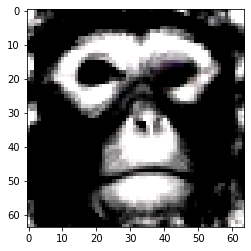

In [550]:
plt.imshow(out['slicers.decoder__output_conv'][18].swapaxes(0, 1).swapaxes(1, 2))

In [436]:
out['slicers.encoder__linear'].mean(1)

array([0.00453787, 0.00453787, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00453787, 0.00453787,
       0.00453788, 0.00453787, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00453787, 0.00506037, 0.00506037, 0.00506037],
      dtype=float32)

In [437]:
out['model.encoder.linear'].mean(1)

array([0.00453787, 0.00453787, 0.00453787, 0.00453787, 0.00453787,
       0.00453787, 0.00453787, 0.00453787, 0.00453787, 0.00453787,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00506039, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506037,
       0.00453787, 0.00453787, 0.00453787, 0.00453787, 0.00453787,
       0.00453787, 0.00453787, 0.00453787, 0.00453787, 0.00453786,
       0.00453788, 0.00453787, 0.00453787, 0.00453787, 0.00453787,
       0.00453787, 0.00453787, 0.00453787, 0.00453787, 0.00453787,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506037,
       0.00506037, 0.00506037, 0.00506037, 0.00506037, 0.00506

In [195]:
wrapper

Slicer(
  (model): FitVid(
    (encoder): NvaeEncoder(
      (blocks): ModuleList(
        (0): ModuleList(
          (0): EncoderBlock(
            (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
            (shortcut): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (normalize_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (normalize_hidden): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (normalize_residual): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (se): SEBlock(
              (squeeze): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
              (expand): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
            )
            (act): SiLU()
          )
          (1): Encode

In [363]:
out1 = wrapper.get_activations(images[:1], ['model.encoder.blocks.0.1.act'])

torch.Size([5, 512, 8, 8])


In [156]:
out1['model.encoder.blocks.0.1.act'].shape

(5, 512, 8, 8)

In [69]:
output = wrapper(image_filepaths[:1], layers=['encoder.blocks.0.1.act'])

layer packaging:   0%|                                                            | 0/1 [00:00<?, ?it/s]

AssertionError: 